In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import mysql.connector.pooling
import os
import logging

logger = logging.getLogger()

In [3]:
from dialog_agent_service import init_mysql_db

In [4]:
mysql_pool = init_mysql_db()

In [8]:
from dialog_agent_service.db import get_mysql_cnx_cursor

query = """
select fq.merchantId, fq.text as 'question', fa.text as 'answer' from faqs fq join faqs fa on fq.answerId = fa.id where fq.type = 'question'
"""
with get_mysql_cnx_cursor() as cursor:
    cursor.execute(query)
    data = cursor.fetchall()

In [9]:
len(data)

430

In [23]:
# get merchantId to vendorName
query = """
select id, name from vendors
"""
with get_mysql_cnx_cursor() as cursor:
    cursor.execute(query)
    merchants = cursor.fetchall()

In [24]:
id2merchant = {str(item['id']): item['name'] for item in merchants}

In [43]:
from dialog_agent_service.conversational_agent.chatgpt import answer_with_prompt

In [10]:
data[0]

{'merchantId': 33,
 'question': 'When can I expect my Holiday Beauty Event order to arrive?',
 'answer': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take approximately 3-7 days to arrive at its destination. International orders can take anywhere between 15-25 days for delivery.'}

In [44]:
from dialog_agent_service.conversational_agent.task_handlers.handle_answer_miscellaneous_questions import handle_answer_miscellaneous_questions
from dialog_agent_service.conversational_agent.conversation_parser import Conversation


## experiment

In [41]:
convo = Conversation([('inbound', data[0]['question'])])

In [42]:
handle_answer_miscellaneous_questions(
    cnv_obj=convo, 
    merchant_id=str(data[0]['merchantId']),
    vendor=id2merchant[str(data[0]['merchantId'])]
)

{'handoff': False,
 'response': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take approximately 3-7 days to arrive at its destination. International orders can take anywhere between 15-25 days for delivery.'}

## single threaded requests

In [25]:
queries = []
for item in data:
    convo = Conversation([('inbound', item['question'])])
    q_args = (convo, str(item['merchantId']), id2merchant[str(item['merchantId'])])
    queries.append(q_args)

In [46]:
results = []
for idx, (convo, merchant_id, merchant_name) in tqdm.tqdm(enumerate(queries), total=len(queries)):
    rslt = {
        'merchant_id': merchant_id,
        'merchant_name': merchant_name,
        'question': str(convo),
        'ground_truth': data[idx]['answer']
    }
    
    try:
        resp = handle_answer_miscellaneous_questions(convo, merchant_id, merchant_name)
        rslt['bot_answer'] = resp.get('response')
    except Exception as e:
        print(idx, e)
    results.append(rslt)
        
        
    

  0%|▌                                                                                                                | 2/430 [00:20<1:14:42, 10.47s/it]


In [47]:
results

[{'merchant_id': '33',
  'merchant_name': 'AAVRANI',
  'question': 'Buyer: When can I expect my Holiday Beauty Event order to arrive?',
  'ground_truth': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take approximately 3-7 days to arrive at its destination. International orders can take anywhere between 15-25 days for delivery.',
  'bot_answer': 'Hi there! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take app

In [48]:
import json   
with open('qa_chatgpt_3.5.json', 'w') as f:
    json.dump(results, f)

## concurrent queries:
1) not possible due to gql client being sync and we cannot instantiate multiple clients 
2) openai rate limiting
 That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 53b4f993b56f5eb777b4f3f821c6f4b7 in your message.)

In [26]:
queries[0]

(<dialog_agent_service.conversational_agent.conversation_parser.Conversation at 0x7fe6e979bac0>,
 '33',
 'AAVRANI')

In [30]:
str(convo)

'Buyer: Can I cancel my order?'

In [45]:
import tqdm
import concurrent.futures

def get_qa(convo, merchant_id, merchant_name):
    """
    Args:
        convo: Conversation obj
        idx: to keep track of the indices in the FAQs
    """
    resp = handle_answer_miscellaneous_questions(
        cnv_obj=convo,
        merchant_id=merchant_id,
        vendor=merchant_name
    )
    return resp
    
responses = []
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    future_to_url = {executor.submit(get_qa, convo, merchant_id, merchant_name): 
                     (idx, merchant_name, str(convo)) for idx, (convo, merchant_id, merchant_name) in enumerate(queries[:5])}
    for future in concurrent.futures.as_completed(future_to_url):
        idx, merchant_name, convo = future_to_url[future]
        try:
            resp = future.result()
        except Exception as exc:
            print(f'Convo {idx} generated an exception: {exc}')
        else:
            responses.append((idx, resp))


/var/folders/t6/nfz7c9013f75jjx506l2qvp80000gn/T/ipykernel_56257/1123582815.py:19: RuntimeWarning: coroutine 'get_qa' was never awaited
  future_to_url = {executor.submit(get_qa, convo, merchant_id, merchant_name):
/var/folders/t6/nfz7c9013f75jjx506l2qvp80000gn/T/ipykernel_56257/1123582815.py:24: RuntimeWarning: coroutine 'get_qa' was never awaited
  resp = future.result()


Convo 1 generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 53b4f993b56f5eb777b4f3f821c6f4b7 in your message.)


In [1]:
import json
with open('qa_chatgpt_3.5.json') as f:
    data_3 = json.load(f)

In [2]:
with open('qa_chatgpt_4.json') as f:
    data_4 = json.load(f)

In [3]:
data_3[0]

{'merchant_id': '33',
 'merchant_name': 'AAVRANI',
 'question': 'Buyer: When can I expect my Holiday Beauty Event order to arrive?',
 'ground_truth': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take approximately 3-7 days to arrive at its destination. International orders can take anywhere between 15-25 days for delivery.',
 'bot_answer': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be 

In [4]:
data_4[0]

{'merchant_id': '33',
 'merchant_name': 'AAVRANI',
 'question': 'Buyer: When can I expect my Holiday Beauty Event order to arrive?',
 'ground_truth': 'Please know that we are working as hard as we can to get your order to you! If you place an order before 12 P.M. EST on a business day, you can expect your order to ship out that same day. If you place an order after 12 P.M. EST on a business day or on a weekend/holiday, it will take 1-2 business days for your order to be fulfilled and shipped. Once shipped, domestic orders take approximately 3-7 days to arrive at its destination. International orders can take anywhere between 15-25 days for delivery.',
 'bot_answer': 'Hi there! If you place an order before 12 P.M. EST on a business day, it will likely ship the same day. Orders placed after 12 P.M. EST or on weekends/holidays take 1-2 business days to be fulfilled and shipped. Domestic orders take approximately 3-7 days to arrive, while international orders take 15-25 days for delivery.'

In [15]:
import pandas as pd

df_3 = pd.DataFrame(data_3)

In [16]:
df_4 = pd.DataFrame(data_4)

In [18]:
df_3.shape, df_4.shape

((430, 5), (430, 5))

In [22]:
df_3[df_3.question.duplicated()].shape

(16, 5)

In [26]:
df_merged = df_3.merge(df_4[['merchant_id', 'question', 'ground_truth', 'bot_answer']], on=['merchant_id', 'question', 'ground_truth'], how='inner', suffixes=["_3.5", "_4"])

In [30]:
df_merged = df_merged.drop_duplicates(subset=['merchant_id', 'question', 'ground_truth'])

In [31]:
df_merged = df_merged.fillna('')

In [32]:
df_merged.to_csv("qa_eval_1.csv", index=False)

In [86]:
from rouge import Rouge
from sacrebleu.metrics import BLEU
rouge = Rouge()
bleu = BLEU(lowercase=True, effective_order=True)

In [42]:
def get_rouge(hyp, ref, n_gram=1):
    hyp = " ".join(sorted(hyp))
    ref = " ".join(sorted(ref))
    if ref == '' and hyp == '': 
        return {f'rouge-{n_gram}': {'r': 1.0, 'p': 1.0, 'f': 1.0}}
        # is empty, whatever in hyp is not precise and recall is also 0
    elif ref == '' or hyp == '':
        return {f'rouge-{n_gram}': {'r': 0.0, 'p': 0.0, 'f': 0.0}}
    else:
        return rouge.get_scores(hyps=hyp, refs=ref, ignore_empty=True)[0]

In [51]:
def get_rouge_scores(refs, hyps, metric='f', n_gram=1):
    scores = []
    for ref, hyp in zip(refs, hyps):
        scores.append(get_rouge(hyp, ref, n_gram=n_gram))
    scores = [score[f'rouge-{n_gram}'][metric] for score in scores]
    return scores
    

In [52]:
df_merged.head(1)

,merchant_id,merchant_name,question,ground_truth,bot_answer_3.5,bot_answer_4
0,33,AAVRANI,Buyer: When can I expect my Holiday Beauty Eve...,Please know that we are working as hard as we ...,Please know that we are working as hard as we ...,Hi there! If you place an order before 12 P.M....


In [81]:
rouge_f_scores = get_rouge_scores(refs=df_merged.ground_truth.tolist(), hyps=df_merged['bot_answer_3.5'].tolist(), metric='f')


In [77]:
rouge_r_scores = scores

{'whiskers': [<matplotlib.lines.Line2D at 0x164bd85b0>,
 'caps': [<matplotlib.lines.Line2D at 0x164bd86a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x164bdbac0>],
 'medians': [<matplotlib.lines.Line2D at 0x164bdadd0>],
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x164bd9360>]}

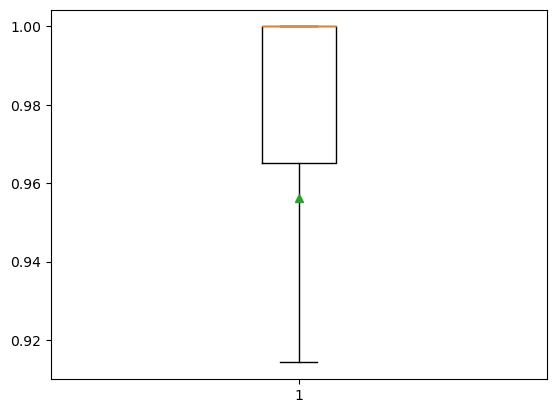

In [50]:
import matplotlib.pyplot as plt
plt.boxplot(scores, showfliers=False, showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x164c119c0>,
 'caps': [<matplotlib.lines.Line2D at 0x164c10ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x164c11db0>],
 'medians': [<matplotlib.lines.Line2D at 0x164c13c40>],
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x164c13a60>]}

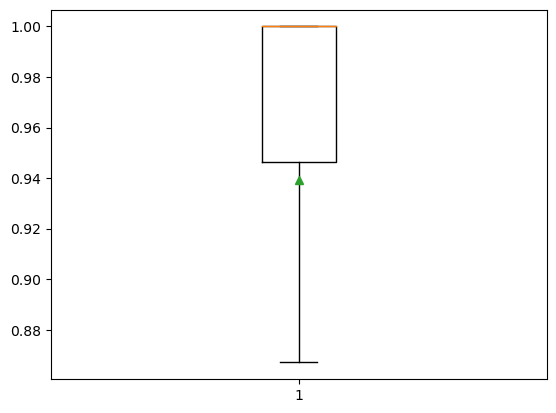

In [54]:
plt.boxplot(bigram_scores, showfliers=False, showmeans=True)

In [83]:
import numpy as np
np.array(rouge_f_scores).mean()

0.9563453036142985

In [63]:
df_merged[df_merged['bot_answer_3.5'] == ''].shape

(6, 6)

In [64]:
df_merged_only_generated = df_merged[df_merged['bot_answer_3.5'] != '']

In [66]:
bl_score = bleu.corpus_score(hypotheses=df_merged['bot_answer_3.5'].tolist(), references=[df_merged_only_generated['ground_truth'].tolist()])

In [97]:
bl_score.score, bl_score.bp, bl_score.precisions

(77.67267658501582,
 0.8360251418135723,
 [95.95843972880162, 93.46460931192249, 91.79391057876931, 90.50060594760883])

In [99]:
bl_scores = [bleu.sentence_score(hypothesis=hyp, references=[ref]) for hyp, ref in zip(df_merged['bot_answer_3.5'].tolist(), df_merged_only_generated['ground_truth'].tolist())]



In [95]:
df_merged.iloc[100].values

array(['32', 'Freestyle Snacks',
       "Buyer: Aren't there other bamboo diapers?",
       'There are others who claim to sell "bamboo diapers," but their fingers must be crossed behind their backs when they say that -- they only use bamboo for the outer-most liner of the diaper.\n\n45-50% of the weight of the diaper is in the pulp, that white fluffy middle of the diaper that does all of the absorbing. And everyone in the US diaper market -- including those other brands claiming to sell "bamboo" diapers -- uses wood for their diaper pulp. Meaning they cut down over 1 billion trees a year to make the majority of the materials used in the diaper.\n\nNot us. We use sustainable, regenerative bamboo for our pulp. Seriously difficult to do, but worth it because it regrows in 60 days and it\'s more absorbent.',
       'There are other brands that claim to sell "bamboo diapers," but they only use bamboo for the outer-most liner of the diaper. We use sustainable, regenerative bamboo for our pu

In [100]:
bl_scores[100].score, bl_scores[100].precisions, bl_scores[100].bp

(0.9995102003472773,
 [13.114754098360656,
  0.8333333333333334,
  0.423728813559322,
  0.21551724137931033],
 1.0)

In [84]:
bl_score.precisions

[95.95843972880162, 93.46460931192249, 91.79391057876931, 90.50060594760883]